In [1]:
import time
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM
import numpy as np
import pandas as pd
import sklearn.preprocessing as prep
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#### Import Data

In [2]:
data = pd.read_csv('nyse_2001-2021.csv')
df=data
df.head()


,Date,Low,Open,Volume,High,Close,Adjusted Close
0,29-11-2001,13.360000,13.386667,371100,14.466667,13.880000,12.583543
1,30-11-2001,13.880000,13.880000,165300,14.266667,14.266667,12.934094
2,03-12-2001,13.783333,14.233333,127500,14.233333,13.783333,12.495903
3,04-12-2001,13.233333,13.783333,95400,13.783333,13.233333,11.997280
4,05-12-2001,13.433333,13.433333,598200,14.783333,14.666667,13.296731


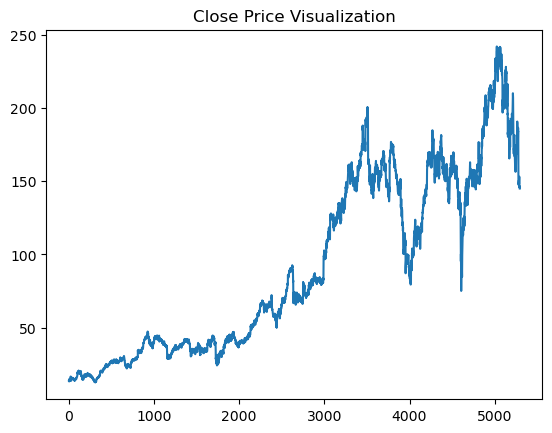

In [3]:
plt.title("Close Price Visualization")
plt.plot(df.Close)

### Defining 200 days moving averages and plotting comparision graph with 100 days moving averages

In [4]:
ma100 = df.Close.rolling(100).mean()
ma100



0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
5291    176.1565
5292    175.7703
5293    175.3297
5294    174.8621
5295    174.4132
Name: Close, Length: 5296, dtype: float64

Text(0.5, 1.0, 'Graph Of Moving Averages Of 100 Days')

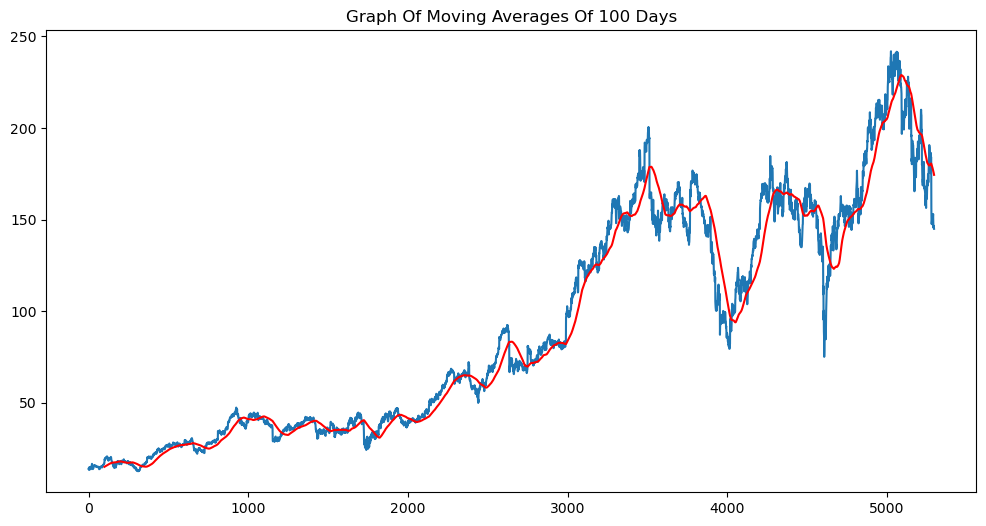

In [5]:
plt.figure(figsize = (12,6))
plt.plot(df.Close)
plt.plot(ma100, 'r')
plt.title('Graph Of Moving Averages Of 100 Days')

In [6]:
ma200 = df.Close.rolling(200).mean()
ma200

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
          ...    
5291    187.62320
5292    187.32265
5293    187.07160
5294    186.79705
5295    186.49390
Name: Close, Length: 5296, dtype: float64

Text(0.5, 1.0, 'Comparision Of 100 Days And 200 Days Moving Averages')

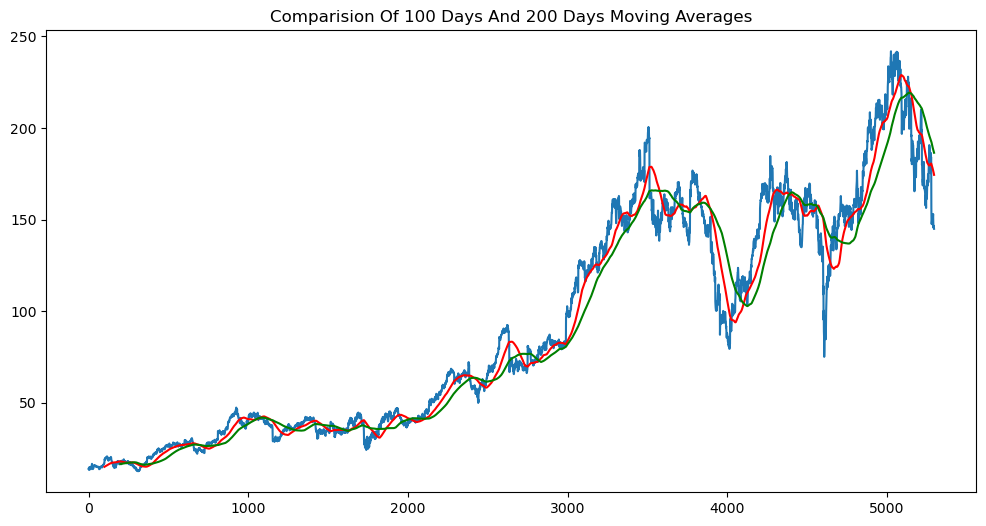

In [7]:

plt.figure(figsize = (12,6))
plt.plot(df.Close)
plt.plot(ma100, 'r')
plt.plot(ma200, 'g')
plt.title('Comparision Of 100 Days And 200 Days Moving Averages')

### Data preprocessing

In [8]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Use only the "Close" column for simplicity
close_prices = data['Close'].values.reshape(-1, 1)




C:\Users\stella\AppData\Local\Temp\ipykernel_16016\1768896307.py:4: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['Date'] = pd.to_datetime(data['Date'])


In [9]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)


#### Splitting data into train, validation, test dataset

In [10]:
N = 100  # use the past 100 days data
M=5 # predict the next 5 days data
# Create sequences
def create_sequences(data, N, M):
    X, y = [], []
    for i in range(len(data) - N - M + 1):
        X.append(data[i:i + N])
        y.append(data[i + N:i + N + M])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, N, M)

# Split into train, validation, and test sets
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

# Reshape for LSTM (samples, timesteps, features)
y_train = y_train.reshape(-1, M)
y_val = y_val.reshape(-1, M)
y_test = y_test.reshape(-1, M)

In [11]:
X_train.shape
X_train.shape[1]

100

In [12]:
y_val.shape

(778, 5)

### Building LSTM model

In [15]:
# Define LSTM model
import tensorflow as tf
def build_lstm(input_shape, units=50, learning_rate=0.001, dropout_rate=0.2):
    model = Sequential([
        LSTM(units, activation='tanh', input_shape=input_shape, dropout=dropout_rate),
        Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
    return model


In [16]:
model = build_lstm((X_train.shape[1], X_train.shape[2]))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                10400     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [18]:
import optuna

def objective(trial):
    # Suggest hyperparameters
    units = trial.suggest_int('units', 30, 80)
    dropout_rate=trial.suggest_float('drop_out',0.2,0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [128,256])

    # Build the model
    model = build_lstm(((X_train.shape[1], X_train.shape[2])), units, learning_rate, dropout_rate)
     # Early stopping

    # Train the model
    history = model.fit(
        X_train, y_train, 
        validation_data=(X_val, y_val), 
        batch_size=batch_size, 
        epochs=10, 
        verbose=0
    )
    val_loss = min(history.history['val_loss'])  # Get the best validation loss
    return val_loss

# Hyperparameter tuning with Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# Best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2024-12-06 13:10:00,924] A new study created in memory with name: no-name-6cd730ef-8cb5-42db-b49b-06b7e3c5f48a
[I 2024-12-06 13:10:15,382] Trial 0 finished with value: 0.0014096604427322745 and parameters: {'units': 30, 'drop_out': 0.30277041319081216, 'learning_rate': 0.007716484062138991, 'batch_size': 128}. Best is trial 0 with value: 0.0014096604427322745.
[I 2024-12-06 13:10:42,254] Trial 1 finished with value: 0.0026670044753700495 and parameters: {'units': 78, 'drop_out': 0.31607624416287705, 'learning_rate': 0.005839828518564731, 'batch_size': 128}. Best is trial 0 with value: 0.0014096604427322745.
[I 2024-12-06 13:11:05,617] Trial 2 finished with value: 0.0008319994667544961 and parameters: {'units': 72, 'drop_out': 0.23114644162638467, 'learning_rate': 0.003193059502317625, 'batch_size': 256}. Best is trial 2 with value: 0.0008319994667544961.
[I 2024-12-06 13:11:28,536] Trial 3 finished with value: 0.001241320394910872 and parameters: {'units': 77, 'drop_out': 0.24938222

Best Hyperparameters: {'units': 53, 'drop_out': 0.20199635832690635, 'learning_rate': 0.009504970039594758, 'batch_size': 256}


In [27]:


# Train the final model using the best hyperparameters

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

final_model = build_lstm(
    (X_train.shape[1], X_train.shape[2]),
    units=best_params['units'],
    learning_rate=round(best_params['learning_rate'],4),
    dropout_rate=round(best_params['drop_out'],2),
)

history = final_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=256,
    epochs=35,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/35
15/15 [==============================] - 5s 158ms/step - loss: 0.0208 - val_loss: 0.0105
Epoch 2/35
15/15 [==============================] - 2s 110ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 3/35
15/15 [==============================] - 2s 114ms/step - loss: 0.0025 - val_loss: 8.7739e-04
Epoch 4/35
15/15 [==============================] - 2s 112ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 5/35
15/15 [==============================] - 2s 117ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 6/35
15/15 [==============================] - 2s 108ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 7/35
15/15 [==============================] - 2s 111ms/step - loss: 0.0010 - val_loss: 0.0024
Epoch 8/35
15/15 [==============================] - 2s 108ms/step - loss: 9.2307e-04 - val_loss: 0.0022


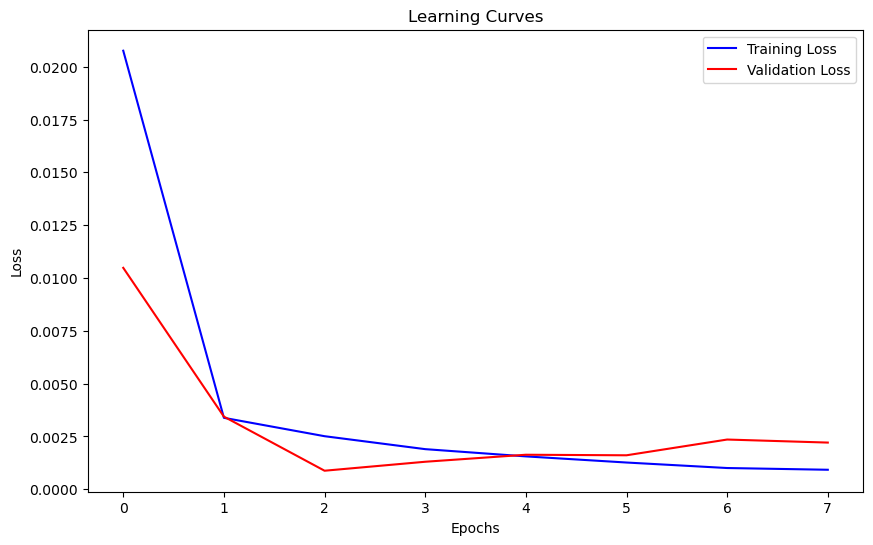

In [28]:
# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.legend()
plt.show()

In [62]:
# Predictions and plot actual vs predicted prices
y_pred = final_model.predict(X_test)



25/25 [==============================] - 0s 12ms/step


In [63]:
# Inverse scale predictions
y_test_scaled = scaler.inverse_transform(y_test)
y_pred_scaled = scaler.inverse_transform(y_pred)

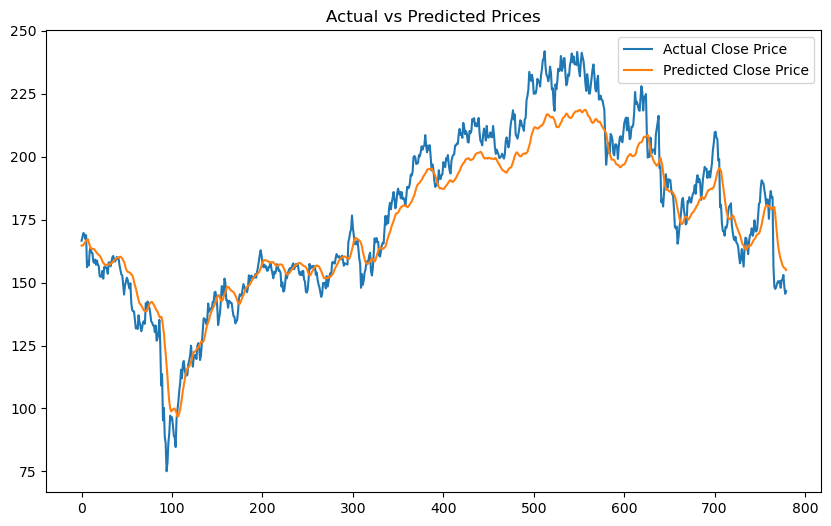

In [64]:


plt.figure(figsize=(10, 6))
plt.plot(y_test_scaled[:,1], label='Actual Close Price ')  # Close price index
plt.plot(y_pred_scaled, label='Predicted Close Price')
plt.legend()
plt.title('Actual vs Predicted Prices')
plt.show()

In [65]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Calculate metrics
mse = mean_squared_error(y_test[:,1], y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test[:,1], y_pred)

# Print results
print(f"Test MSE: {mse:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE: {mae:.2f}")

Test MSE: 0.00
Test RMSE: 0.05
Test MAE: 0.04
